In [1]:
import os
from glob import glob
import dask
import xarray as xr
import cartopy.crs as ccrs
from cmocean import cm
import numpy as np
import xgcm
from scipy.signal import welch
from scipy import signal

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
#cluster = PBSCluster(cores=28, processes=18, walltime='03:00:00')
w = cluster.scale(3)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.16:56153 Dashboard: http://10.148.1.16:8787/status,Cluster Workers: 3 Cores: 84 Memory: 360.00 GB


# Read data

In [5]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

ds_u = xr.open_dataset(out_dir_zarr+'U_surface_rechunk.nc')
ds_v = xr.open_dataset(out_dir_zarr+'V_surface_rechunk.nc')
ds_eta = xr.open_zarr(out_dir_zarr+'Eta_total_rechunk.zarr')

grid = xr.open_dataset(out_dir_zarr+'Grid.nc', decode_coords=True)
ds = xr.merge([ds_u,ds_v,ds_eta,grid])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 ... -14.42 -14.4 -14.38
    depth    float64 0.5
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.94 49.96 49.97 49.98
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
    XC       (lat, lon) float32 ...
    YC       (lat, lon) float32 ...
    XG       (lat_g, lon_g) float32 ...
    YG       (lat_g, lon_g) float32 ...
    CS       (lat, lon) float32 ...
    SN       (lat, lon) float32 ...
    Depth    (lat, lon) float32 ...
    dxC      (lat, lon_g) float32 ...
    dyC      (lat_g, lon) float32 ...
    dxG      (lat_g, lon) float32 ...
    dyG      (lat, lon_g) float32 ...
    rA       (lat, lon) float32 ...
    rAz      (lat_g, lon_g) float

In [6]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'}})
print(gridx)

<xgcm.Grid>
X Axis (periodic):
  * center   lon --> left
  * left     lon_g --> center
Y Axis (periodic):
  * center   lat --> left
  * left     lat_g --> center


In [7]:
g = 9.81

lat = ds['YG']
omega = 7.3/100000
f = 2*omega*np.sin(np.deg2rad(lat))
f_i = gridx.interp(f,'X')
f_j = gridx.interp(f,'Y')
f_ij = gridx.interp(f_i,'Y')
f

<xarray.DataArray 'YG' (lat_g: 201, lon_g: 177)>
array([[0.00010747, 0.00010747, 0.00010747, ..., 0.00010747, 0.00010747,
        0.00010747],
       [0.00010749, 0.00010749, 0.00010749, ..., 0.00010749, 0.00010749,
        0.00010749],
       [0.00010751, 0.00010751, 0.00010751, ..., 0.00010751, 0.00010751,
        0.00010751],
       ...,
       [0.00011177, 0.00011177, 0.00011177, ..., 0.00011177, 0.00011177,
        0.00011177],
       [0.00011179, 0.00011179, 0.00011179, ..., 0.00011179, 0.00011179,
        0.00011179],
       [0.00011181, 0.00011181, 0.00011181, ..., 0.00011181, 0.00011181,
        0.00011181]], dtype=float32)
Coordinates:
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 ... -14.42 -14.4 -14.38
    depth    float64 0.5
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.94 49.96 49.97 49.98
    XG       (lat_g, lon_g) float32 ...
    YG       (lat_g, lon_g) float32 47.39811 47.39811 ... 49.981472 49.981472
    rAz      (lat_g, lon_g) float32 ...

In [92]:
dB_dx_geo = gridx.diff(g*ds['Eta'],'X')/ds.dxC     # d(Eta*g)/dx
dB_dy_geo = gridx.diff(g*ds['Eta'],'Y')/ds.dyC    # d(Eta*g)/dy

u_geo = -dB_dy_geo/f_i
u_geo_ij = gridx.interp(u_geo,'Y')

v_geo = dB_dx_geo/f_j
v_geo_ij = gridx.interp(v_geo,'X')

In [93]:
u_total_ij = gridx.interp(ds.U,'X')
v_total_ij = gridx.interp(ds.V,'Y')

u_ageo_ij = u_total_ij-u_geo_ij
v_ageo_ij = v_total_ij-v_geo_ij

In [94]:
u_total_ij = np.real(u_total_ij).rename('u_total_ij')    
v_total_ij = np.real(v_total_ij).rename('v_total_ij')    
u_geo_ij = np.real(u_geo_ij).rename('u_geo_ij')    
v_geo_ij = np.real(v_geo_ij).rename('v_geo_ij')    
u_ageo_ij = np.real(u_ageo_ij).rename('u_ageo_ij')    
v_ageo_ij = np.real(v_ageo_ij).rename('v_ageo_ij')    


u_total_ij = u_total_ij.chunk({'time': 9415,'lat':201,'lon':177})
v_total_ij = v_total_ij.chunk({'time': 9415,'lat':201,'lon':177})

u_geo_ij = u_geo_ij.chunk({'time': 9415,'lat':201,'lon':177})
v_geo_ij = v_geo_ij.chunk({'time': 9415,'lat':201,'lon':177})

u_ageo_ij = u_ageo_ij.chunk({'time': 9415,'lat':201,'lon':177})
v_ageo_ij = v_ageo_ij.chunk({'time': 9415,'lat':201,'lon':177})

ds_ij = xr.merge([u_total_ij,v_total_ij,u_geo_ij,v_geo_ij,u_ageo_ij,v_ageo_ij,grid])
ds_ij.to_zarr(out_dir_zarr+'uv_surface.zarr', mode='w')

## Read geo., ageo. and total uv

In [8]:
ds_ij = xr.open_zarr(out_dir_zarr+'uv_surface.zarr')
ds_ij

<xarray.Dataset>
Dimensions:     (lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
    CS          (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    Depth       (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    SN          (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    XC          (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    XG          (lat_g, lon_g) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    YC          (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    YG          (lat_g, lon_g) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    dxC         (lat, lon_g) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    dxG         (lat_g, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    dyC         (lat_g, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    dyG         (lat, lon_g) floa

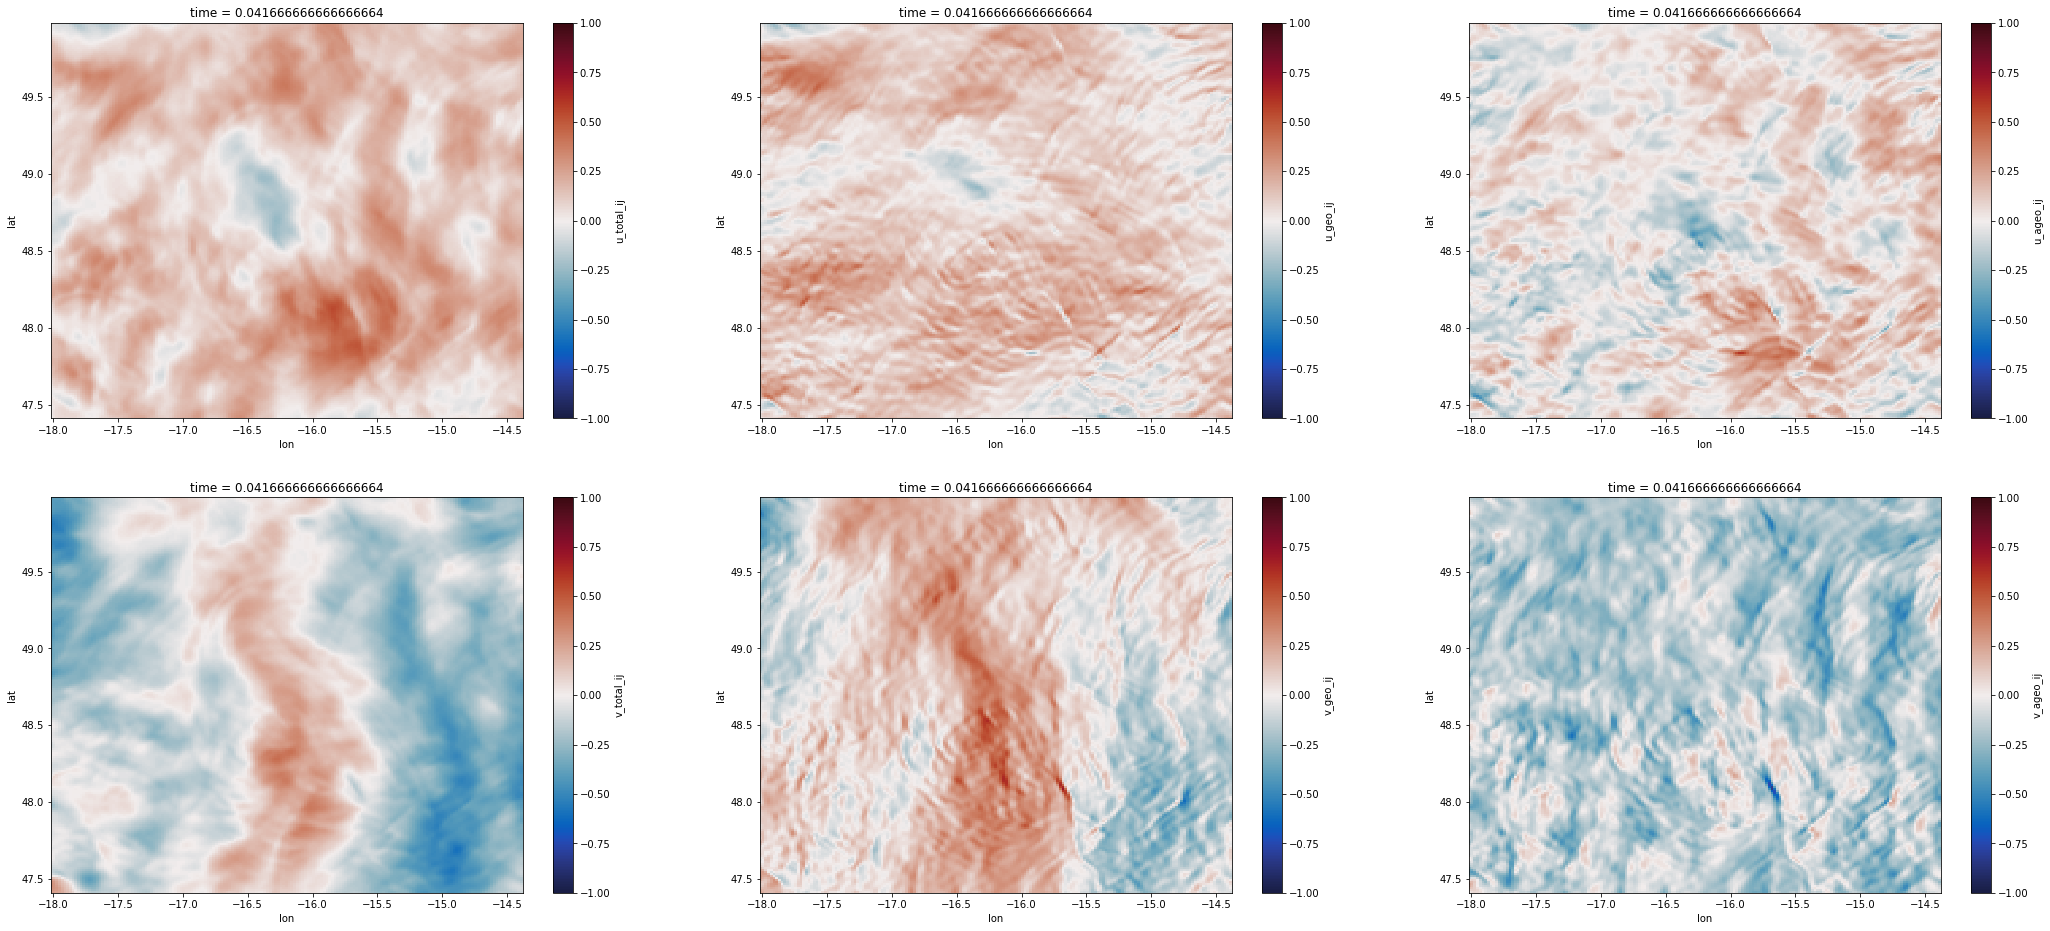

In [9]:
fig = plt.figure(figsize=(36,16))

plt.subplot(231)
ds_ij.u_total_ij.isel(lat=slice(1,-1),lon=slice(1,-1),time=1).plot(x='lon', y='lat', vmin=-1, vmax=1, cmap=cm.balance)
plt.subplot(232)
ds_ij.u_geo_ij.isel(lat=slice(1,-1),lon=slice(1,-1),time=1).plot(x='lon', y='lat', vmin=-1, vmax=1, cmap=cm.balance)
plt.subplot(233)
ds_ij.u_ageo_ij.isel(lat=slice(1,-1),lon=slice(1,-1),time=1).plot(x='lon', y='lat', vmin=-1, vmax=1, cmap=cm.balance)

plt.subplot(234)
ds_ij.v_total_ij.isel(lat=slice(1,-1),lon=slice(1,-1),time=1).plot(x='lon', y='lat', vmin=-1, vmax=1, cmap=cm.balance)
plt.subplot(235)
ds_ij.v_geo_ij.isel(lat=slice(1,-1),lon=slice(1,-1),time=1).plot(x='lon', y='lat', vmin=-1, vmax=1, cmap=cm.balance)
plt.subplot(236)
ds_ij.v_ageo_ij.isel(lat=slice(1,-1),lon=slice(1,-1),time=1).plot(x='lon', y='lat', vmin=-1, vmax=1, cmap=cm.balance)

# Spectra

In [40]:
def _get_E(x, ufunc=True, **kwargs):
    ax = -1 if ufunc else 0
    #
    dkwargs = {'window': 'hann', 'return_onesided': False,'detrend': 'linear', 'scaling': 'density'}
    #dkwargs = {'window': 'boxcar', 'return_onesided': False,'detrend': False, 'scaling': 'density'}
    dkwargs.update(kwargs)
    f, E = signal.welch(x, fs=24., axis=ax, **dkwargs)
    #
    if ufunc:
        return E
    else:
        return f, E

def get_E(v, f=None, **kwargs):
    v = v.chunk({'time': len(v.time)})
    if 'nperseg' in kwargs:
        Nb = kwargs['nperseg']
    else:
        Nb = 60*24
        kwargs['nperseg']= Nb
    if f is None:
        f, E = _get_E(v.values, ufunc=False, **kwargs)
        return f, E
    else:
        E = xr.apply_ufunc(_get_E, v,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['time']],
                    output_core_dims=[['freq_time']],
                    output_sizes={'freq_time': Nb}, kwargs=kwargs)
        return E.assign_coords(freq_time=f).sortby('freq_time')

In [44]:
ds_ij['uv_ageo'] = ds_ij['u_ageo_ij'].fillna(0.) + 1j * ds_ij['v_ageo_ij'].fillna(0.)    

f, E = get_E(ds_ij['uv_ageo'].isel(lat=80,lon=80))
E = get_E(ds_ij['uv_ageo'], f=f)

# store
E = E.to_dataset()
for c in E.coords:
    try:
        del E[c].encoding['chunks']
    except:
        print(c)        
E = E.chunk({'lat': 201, 'lon':177})

Efile = out_dir_zarr+'spectra_uv_ageo.zarr'
%time E.to_zarr(Efile, mode='w')

freq_time
CPU times: user 3.04 s, sys: 2.46 s, total: 5.5 s
Wall time: 1min 14s


In [11]:
ds_ij['uv_geo'] = ds_ij['u_geo_ij'].fillna(0.) + 1j * ds_ij['v_geo_ij'].fillna(0.)    

f, E = get_E(ds_ij['uv_geo'].isel(lat=80,lon=80))
E = get_E(ds_ij['uv_geo'], f=f)

# store
E = E.to_dataset()
for c in E.coords:
    try:
        del E[c].encoding['chunks']
    except:
        print(c)        
E = E.chunk({'lat': 201, 'lon':177})

Efile = out_dir_zarr+'spectra_uv_geo.zarr'
%time E.to_zarr(Efile, mode='w')

freq_time
CPU times: user 3.09 s, sys: 1.1 s, total: 4.19 s
Wall time: 1min 22s


In [41]:
ds_ij['uv_total'] = ds_ij['u_total_ij'].fillna(0.) + 1j * ds_ij['v_total_ij'].fillna(0.)    

f, E = get_E(ds_ij['uv_total'].isel(lat=80,lon=80))
E = get_E(ds_ij['uv_total'], f=f)

# store
E = E.to_dataset()
for c in E.coords:
    try:
        del E[c].encoding['chunks']
    except:
        print(c)        
E = E.chunk({'lat': 201, 'lon':177})

Efile = out_dir_zarr+'spectra_uv_total_detrend.zarr'
%time E.to_zarr(Efile, mode='w')

freq_time
CPU times: user 2.94 s, sys: 2.18 s, total: 5.12 s
Wall time: 1min 15s


In [45]:
E_ageo = xr.open_zarr(out_dir_zarr+'spectra_uv_ageo.zarr')
E_geo = xr.open_zarr(out_dir_zarr+'spectra_uv_geo.zarr')
E = xr.open_zarr(out_dir_zarr+'spectra_uv_total.zarr')
E2 = xr.open_zarr(out_dir_zarr+'spectra_uv_total_detrend.zarr')

In [46]:
open_ocean_depth = 2000

E = E.assign_coords(freq_cps=E.freq_time / 86400.) 
df=E.freq_cps[1]-E.freq_cps[0]

E_ageo_all = (E_ageo.where(E_ageo.Depth>open_ocean_depth)*df).sum(dim='freq_time')
E_total_all = (E.where(E.Depth>open_ocean_depth)*df).sum(dim='freq_time')

# near-inertial f
f_llc = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.YC))
f_cpd_llc = f_llc*86400/2./np.pi  

# Prediction
E_omega = (E.where((abs(E.freq_time)>abs(f_cpd_llc)) & (E.Depth>open_ocean_depth), other=0.)*df*((E.freq_time/f_cpd_llc)**2)).sum(dim='freq_time')    

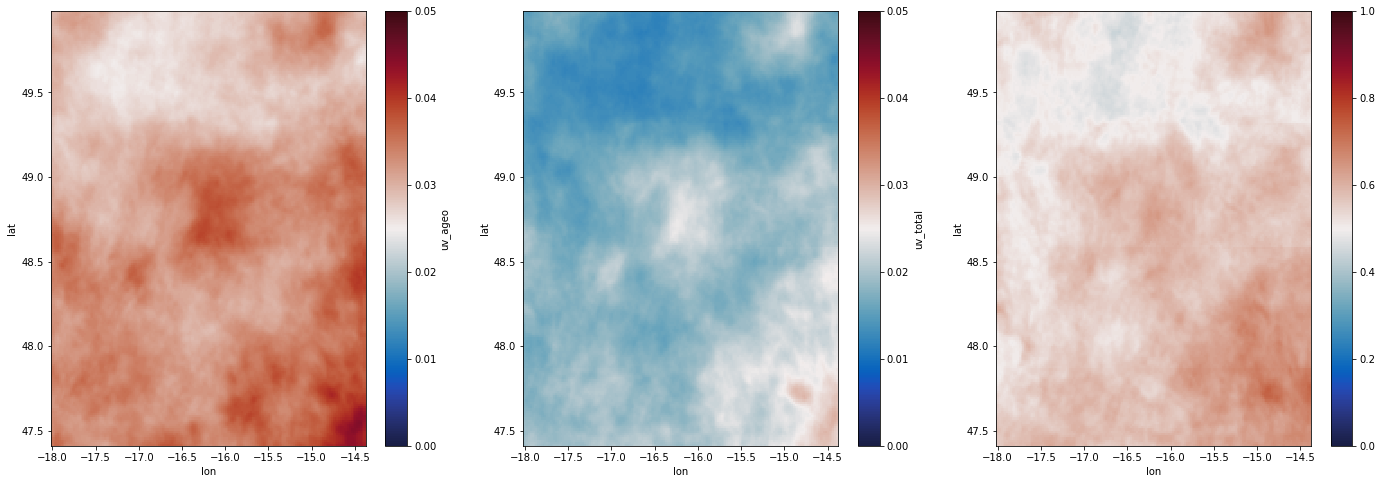

In [47]:
fig = plt.figure(figsize=(24,8))

plt.subplot(131)
(E_ageo_all.uv_ageo.isel(lat=slice(1,-1),lon=slice(1,-1))*86400).plot(vmin=0,vmax=0.05, cmap=cm.balance)
plt.subplot(132)
(E_omega.uv_total.isel(lat=slice(1,-1),lon=slice(1,-1))*86400).plot(vmin=0,vmax=0.05,cmap=cm.balance)
plt.subplot(133)
( E_omega.uv_total.isel(lat=slice(1,-1),lon=slice(1,-1))/E_ageo_all.uv_ageo.isel(lat=slice(1,-1),lon=slice(1,-1))).plot(vmin=0,vmax=1,cmap=cm.balance)

In [48]:
( E_omega.uv_total.isel(lat=slice(1,-1),lon=slice(1,-1))/E_ageo_all.uv_ageo.isel(lat=slice(1,-1),lon=slice(1,-1))).mean(['lat','lon']).values

array(0.56002609)

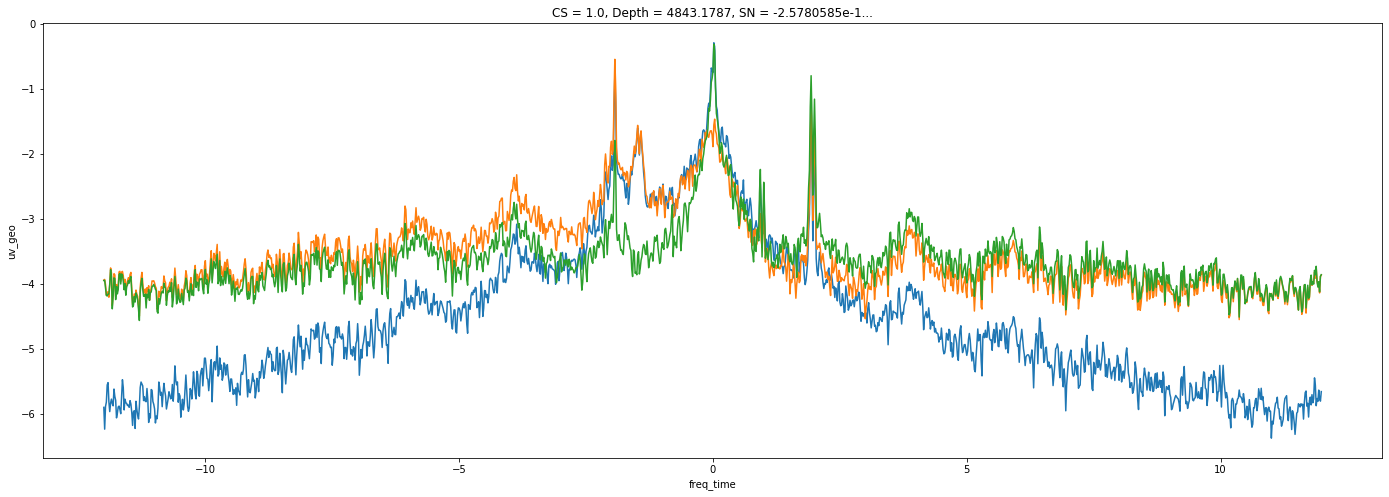

In [13]:
fig = plt.figure(figsize=(24,8))
plt.subplot(111)
np.log10(E.uv_total.isel(lat=90,lon=90)).plot()
np.log10(E_ageo.uv_ageo.isel(lat=90,lon=90)).plot()
np.log10(E_geo.uv_geo.isel(lat=90,lon=90)).plot()

# Surface KE and Rossby number

In [49]:
lat = ds['YG']
omega = 7.3/100000
f = 2*omega*np.sin(np.deg2rad(lat))
f_i = gridx.interp(f,'X')
f_j = gridx.interp(f,'Y')
f_ij = gridx.interp(f_i,'Y')
f

<xarray.DataArray 'YG' (lat_g: 201, lon_g: 177)>
array([[0.00010747, 0.00010747, 0.00010747, ..., 0.00010747, 0.00010747,
        0.00010747],
       [0.00010749, 0.00010749, 0.00010749, ..., 0.00010749, 0.00010749,
        0.00010749],
       [0.00010751, 0.00010751, 0.00010751, ..., 0.00010751, 0.00010751,
        0.00010751],
       ...,
       [0.00011177, 0.00011177, 0.00011177, ..., 0.00011177, 0.00011177,
        0.00011177],
       [0.00011179, 0.00011179, 0.00011179, ..., 0.00011179, 0.00011179,
        0.00011179],
       [0.00011181, 0.00011181, 0.00011181, ..., 0.00011181, 0.00011181,
        0.00011181]], dtype=float32)
Coordinates:
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 ... -14.42 -14.4 -14.38
    depth    float64 0.5
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.94 49.96 49.97 49.98
    XG       (lat_g, lon_g) float32 ...
    YG       (lat_g, lon_g) float32 47.39811 47.39811 ... 49.981472 49.981472
    rAz      (lat_g, lon_g) float32 ...

In [50]:
KE = (gridx.interp(ds['U']**2,'X') + gridx.interp(ds['V']**2,'Y'))/2 # KE
KE_mean = KE.mean(['time'])
KE_mean

<xarray.DataArray (lat: 201, lon: 177)>
array([[0.04319797, 0.04330428, 0.04351582, ..., 0.05781198, 0.05852007,
        0.053565  ],
       [0.04369234, 0.04398664, 0.04434787, ..., 0.05787188, 0.05829379,
        0.05331719],
       [0.0441443 , 0.04458263, 0.04500643, ..., 0.05768917, 0.05784923,
        0.05289084],
       ...,
       [0.04168917, 0.04149244, 0.041433  , ..., 0.02733007, 0.02772334,
        0.034201  ],
       [0.04104917, 0.04068866, 0.04056475, ..., 0.02753377, 0.02795749,
        0.03401329],
       [0.04382047, 0.04357547, 0.04347857, ..., 0.03454362, 0.03518496,
        0.04072779]], dtype=float32)
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [51]:
zeta = (gridx.diff(ds.dyC*ds['V'],'X') - gridx.diff(ds.dxC * ds['U'],'Y'))/ds.rAz
Ro2 = (zeta/f)**2
Ro2_i = gridx.interp(Ro2,'X')
Ro2_ij = gridx.interp(Ro2_i,'Y')
Ro2_ij_mean = Ro2_ij.mean(['time'])

In [54]:
term1 = E_total_all.uv_total*Ro2_ij_mean*86400
term2 = KE_mean*Ro2_ij_mean

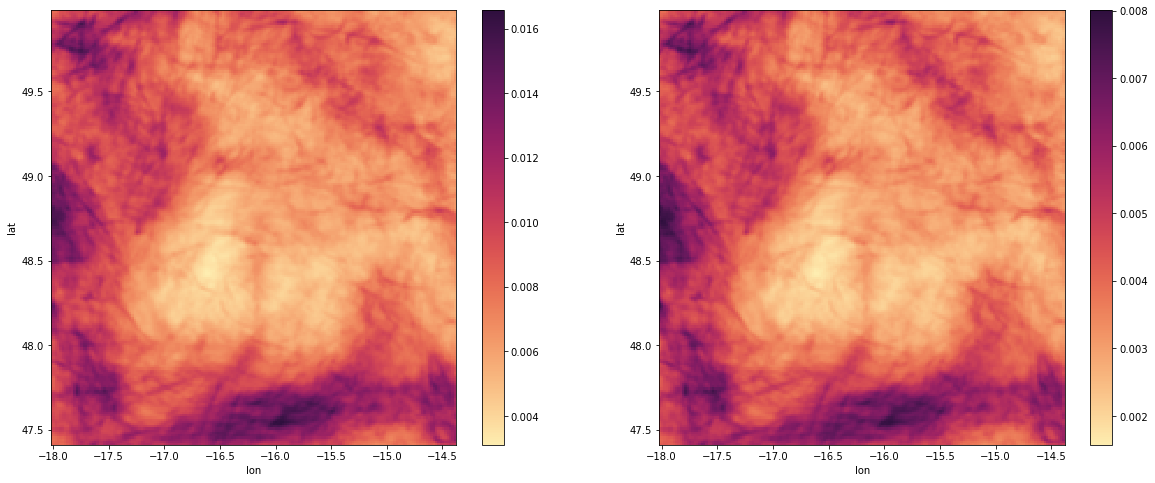

In [55]:
fig = plt.figure(figsize=(20,8))

plt.subplot(121)
(term1.isel(lat=slice(1,-1),lon=slice(1,-1))).plot(cmap=cm.matter)
plt.subplot(122)
(term2.isel(lat=slice(1,-1),lon=slice(1,-1))).plot(cmap=cm.matter)


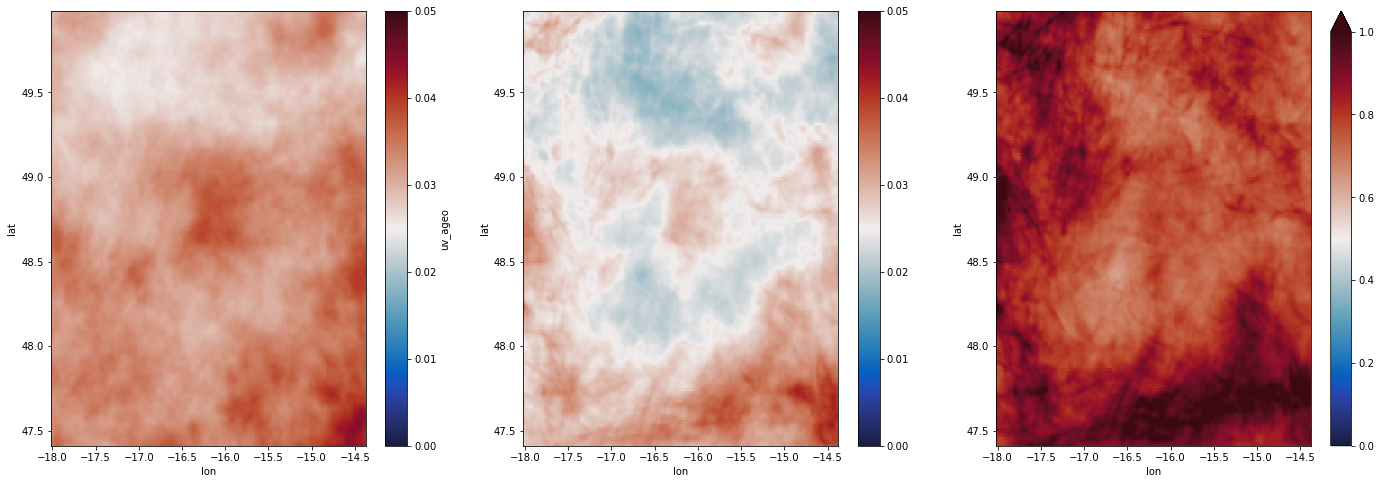

In [64]:
fig = plt.figure(figsize=(24,8))

plt.subplot(131)
(E_ageo_all.uv_ageo.isel(lat=slice(1,-1),lon=slice(1,-1))*86400).plot(vmin=0,vmax=0.05, cmap=cm.balance)
plt.subplot(132)
(E_omega.uv_total.isel(lat=slice(1,-1),lon=slice(1,-1))*86400 + term1.isel(lat=slice(1,-1),lon=slice(1,-1)) ).plot(vmin=0,vmax=0.05,cmap=cm.balance)
plt.subplot(133)
(( E_omega.uv_total.isel(lat=slice(1,-1),lon=slice(1,-1))*86400 + term1.isel(lat=slice(1,-1),lon=slice(1,-1))) / (E_ageo_all.uv_ageo.isel(lat=slice(1,-1),lon=slice(1,-1))*86400) ).plot(vmin=0,vmax=1,cmap=cm.balance)

In [63]:
(( E_omega.uv_total.isel(lat=slice(1,-1),lon=slice(1,-1))*86400+ term1.isel(lat=slice(1,-1),lon=slice(1,-1))) / (E_ageo_all.uv_ageo.isel(lat=slice(1,-1),lon=slice(1,-1))*86400 )).mean(['lat','lon']).values

array(0.82044585)

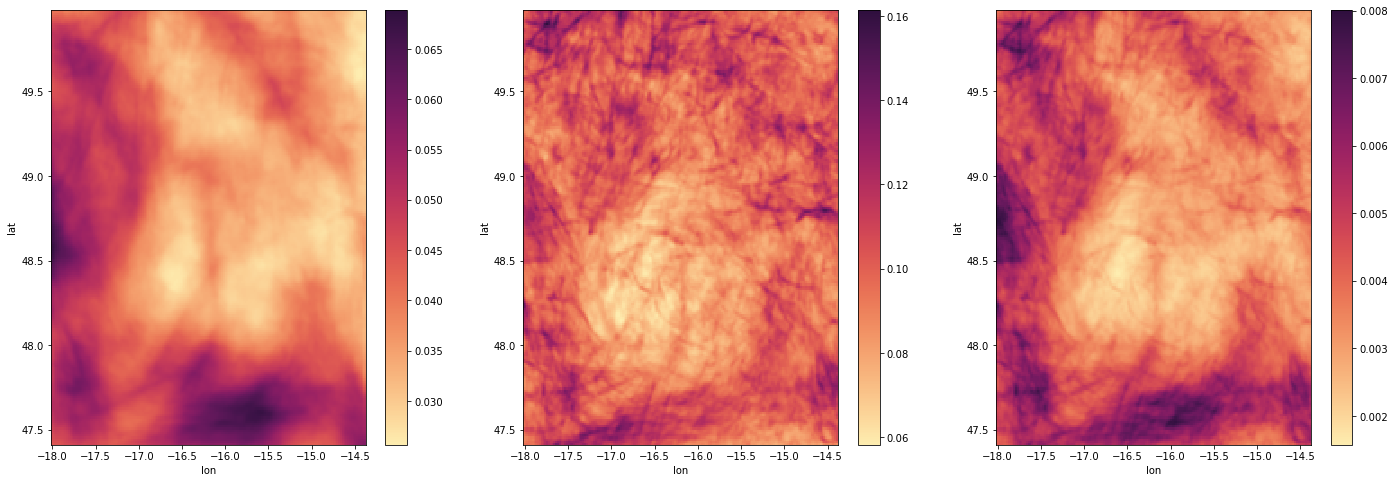

In [117]:
fig = plt.figure(figsize=(24,8))

plt.subplot(131)
(KE_mean.isel(lat=slice(1,-1),lon=slice(1,-1))).plot(cmap=cm.matter)
plt.subplot(132)
(Ro2_ij_mean.isel(lat=slice(1,-1),lon=slice(1,-1))).plot(cmap=cm.matter)
plt.subplot(133)
term2.isel(lat=slice(1,-1),lon=slice(1,-1)).plot(cmap=cm.matter)

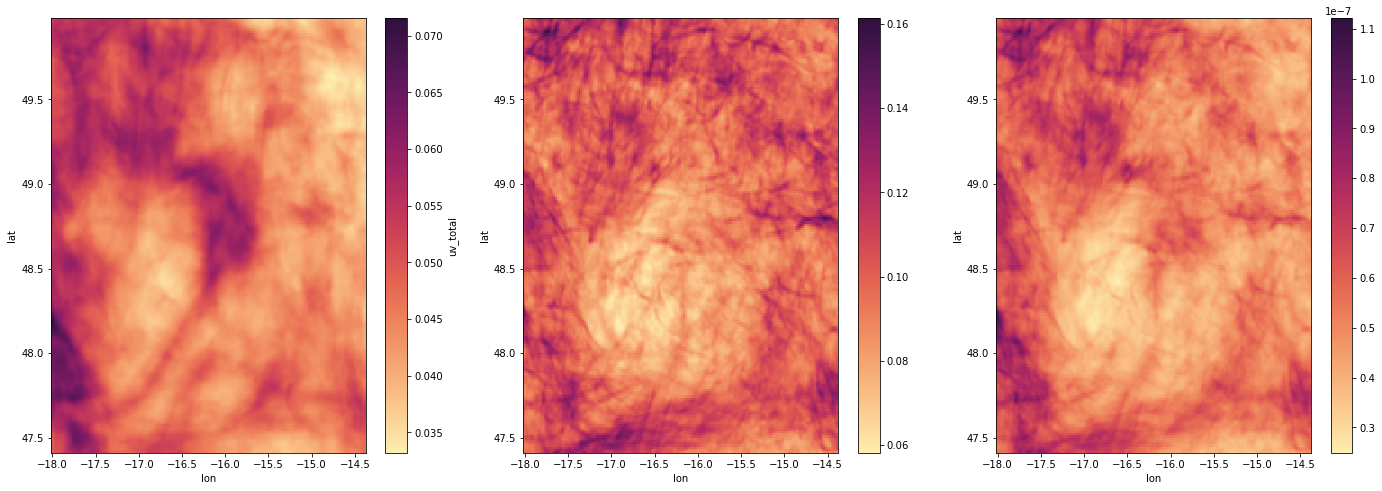

In [126]:
fig = plt.figure(figsize=(24,8))

plt.subplot(131)
(E_total_all.uv_total.isel(lat=slice(1,-1),lon=slice(1,-1))*86400).plot(cmap=cm.matter)
plt.subplot(132)
(Ro2_ij_mean.isel(lat=slice(1,-1),lon=slice(1,-1))).plot(cmap=cm.matter)
plt.subplot(133)
term2.isel(lat=slice(1,-1),lon=slice(1,-1)).plot(cmap=cm.matter)

In [65]:
cluster.close()